## 0. 필요한 패키지 불러오기

In [3]:
import cv2
import numpy as np
import face_recognition
import matplotlib.pyplot as plt
import glob
from urllib.request import urlopen, Request, urlretrieve
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
import pandas as pd
import re

plt.rcParams['font.family'] = 'NanumGothic' # 한글 깨짐 방지

## 1. 사진 모으기

다양한 남자 연예인 데이터를 모으기 위해서 파이썬의 웹스크랩핑 패키지인 urllib, request, BeautifulSoup을 사용하겠습니다.

[얼굴 이미지 데이터에 대한 고찰](https://bcho.tistory.com/1176)을 기반으로 모델이 이미지에서 얼굴을 보다 탐지하기 쉽도록 하기 위해서 되도록이면 얼굴만 보이고 정면을 보고 있는 사진을 선택하겠습니다.

![image](https://user-images.githubusercontent.com/51338268/136311504-d220c740-f90e-4d41-a051-b8e9754ffb7e.png)


수집한 데이터의 종류는 구글 이미지 검색을 통하여 나온 jpg 파일 이미지들을 수집하겠습니다.

처음에는 전체 이미지에서 얼굴이 차지하는 면적이 크고 얼굴의 시선이 정면을 보고 있는 이미지라는 조건에 맞는 남자 연예인 프로필 사진을 위주로 데이터를 수집하려고 했습니다.

하지만, 원하는 방식으로 찍힌 사진의 갯수가 생각한 개수보다 적고, 너무 잘생긴 연예인만 나온다고 판단하여 좀 더 다양한 종류의 연예인 사진을 수집하고자 연예인 이름을 입력하면 구글 이미지 검색에서 제일 먼저 나오는 사진 20개를 수집하는 구조의 웹 스크랩핑 함수를 구현하겠습니다.

In [4]:
# http error 403 error : https://howtoworld.tistory.com/52
def search_download_image(search_image, num_img = 20):
    # 인코딩 문제 : https://hengbokhan.tistory.com/25
    file_name = search_image
    search_url = f"https://www.google.com/search?q={search_image}&hl=ko&sxsrf=AOaemvIvPidTTtt8ykomy5D5RoAkGEesUw:1633581540561&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiU0767vbfzAhXI7WEKHRXXATQQ_AUoAXoECAEQAw&cshid=1633581543322429&biw=1366&bih=625&dpr=1"
    html = requests.get(search_url).content
    bsObject = BeautifulSoup(html, "html.parser")
    imgs = bsObject.select("img")
    urls = [img.attrs["src"] for img in imgs]
    urls = [url for url in urls if re.findall("https:", url)]

    if len(urls) > num_img:
        urls = urls[:num_img]

    for ind, i in enumerate(urls):
        urlretrieve(i, "./data/{0}{1}.jpg".format(file_name, ind))
        
    
search_download_image("김제동")

구글 이미지 검색의 url이 일부분만 바꾸면 이미지만 검색이 가능하여 검색어를 바꿔가며 이미지를 다운로드 받도록 하였습니다.  
```urlretrieve()```함수를 사용하여 request 패키지로 가져온 이미지 url들을 data폴더에 다운로드 받습니다.

In [5]:
def load_images(paths, width=None, height=None):
    result = dict()
    for path in paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if width and height:
            # resize(너비 높이)
            # images.shape(높이, 너비, 채널)
            image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)
        
        name = path.split("/")[-1]
        name = re.sub(".jpg","", name)
        result[name] = image
    return result

paths = sorted(glob.glob("./data/*.jpg"))
images = load_images(paths, 600, 600)

지정된 크기의 이미지들을 가져와서 파일명을 key값으로 두고 이미지 배열을 value로 mapping된 형태의 딕셔너리를 반환합니다.

In [6]:
height, width, channel = images["장동건0"].shape
print(f"높이 : {height}\n너비 : {width}\n채널 수 : {channel}")

높이 : 600
너비 : 600
채널 수 : 3


하나의 이미지의 높이와 너비, 채널 수는 지정되어진 크기로 잘들어왔고, 채널 수는 3개로 컬러 이미지라는 것을 알 수가 있었습니다.

## 2. 얼굴 영역 자르기

In [7]:
def cropping_image(images):
    result = dict()
    true = 0
    false = 1
    false_list = []
    for name, image in tqdm(images.items()):
        try:
            left, top, right, bottom = face_recognition.face_locations(image)[0]
            true += 1
        except:
            false += 1
            false_list += [image]
            continue
        cropped_image = image[left:right, bottom:top, :]
        result[name] = cropped_image
    print(f"얼굴을 찾은 이미지 개수 : {true}\n얼굴을 찾지 못한 이미지 개수 : {false}")
    return result, false_list

cropped_images, false_list = cropping_image(images)

100%|██████████| 162/162 [00:48<00:00,  3.33it/s]

얼굴을 찾은 이미지 개수 : 109
얼굴을 찾지 못한 이미지 개수 : 54


HOG 기반의 얼굴 탐지 메소드인 ```face_locations()```함수를 사용하여 가져온 이미지들의 얼굴의 위치를 찾아서 얼굴을 제외한 나머지 부분은 제거를하여 crop 되어진 이미지를 만들어 줍니다.

가져온 이미지들 중에서 얼굴을 찾은 이미지는 109개이고 찾지 못한 이미지는 54개로 일부 사용하기 좋지 않은 이미지가 섞여있는걸로 판단이 됩니다.

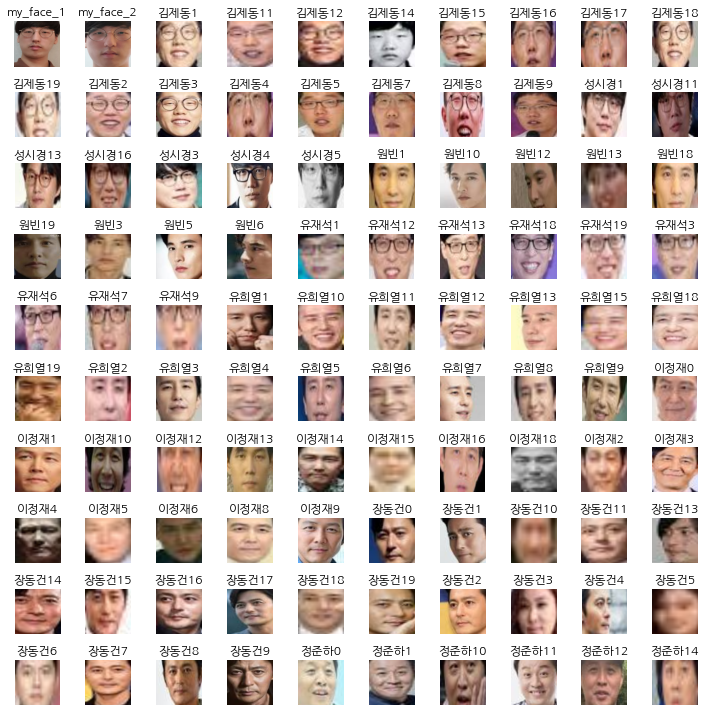

In [8]:
def show_images(images):
    plot_n = int(np.sqrt(len(images)))
    fig, axes = plt.subplots(plot_n, plot_n, figsize=(10, 10))
    if plot_n != 1:
        axes = axes.ravel()
    else:
        axes = [axes]
        
    if re.findall("dict",str(type(images))):
        items = list(images.items())
        for ind, axis in enumerate(axes):
            try:
                axis.imshow(items[ind][1])
                axis.set_title(items[ind][0])
                axis.axis("off")
            except:
                pass
        plt.tight_layout()
        plt.show()
        
    elif re.findall("list",str(type(images))):
        for ind, axis in enumerate(axes):
            try:
                axis.imshow(images[ind])
                axis.axis("off")
            except:
                pass
        plt.tight_layout()
        plt.show()
        
show_images(cropped_images)

얼굴을 찾은 이미지들을 출력하여 데이터를 살펴봅니다.

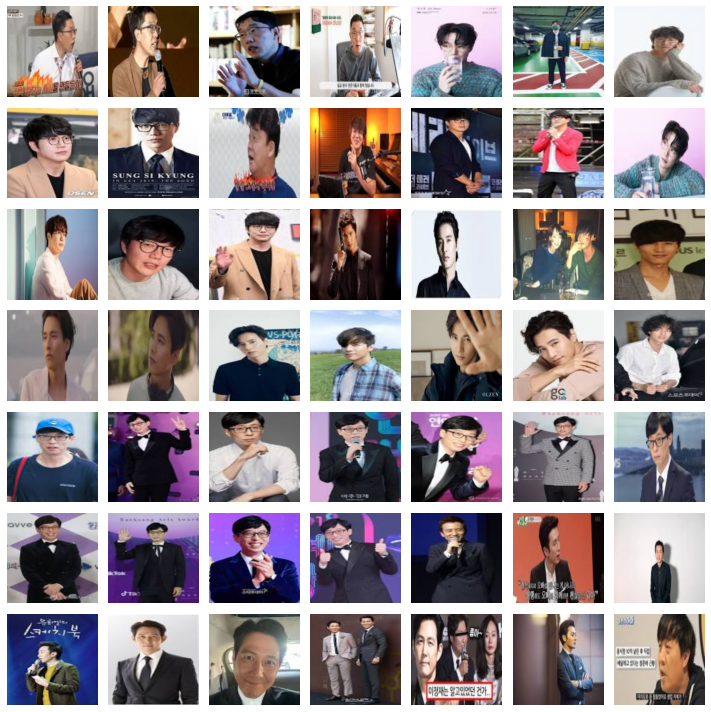

In [9]:
show_images(false_list)

얼굴을 찾지 못한 경우를 살펴보니 많은 데이터들이 얼굴을 충분히 찾을 만한 구조로 이루어져 있는 것으로 보입니다. 

하지만 일부의 이미지의 경우 정면을 보고 있지 않거나 빛으로 인하여 얼굴이 보이지 않는 등의 외부적인 요인이 영향을 주어서 모델이 얼굴을 탐지하지 못하는 것으로 보입니다.

## 3. 얼굴 영역의 임베딩 추출하기

In [10]:
print(f"임베딩 전 데이터 개수 : {len(cropped_images)}")

임베딩 전 데이터 개수 : 109


face embedding을 진행하기 전의 이미지 데이터의 개수는 109개 입니다.

In [11]:
def face_embedding(images):
    result = dict()
    for name, image in images.items():
        embedding = face_recognition.face_encodings(image)
        if len(embedding) != 0:
            result[name] = embedding[0]
    return result

embedding_face = face_embedding(cropped_images)

In [12]:
print(f"임베딩 후 데이터 개수 : {len(embedding_face)}")

임베딩 후 데이터 개수 : 80


## 4. 모은 연예인들과 비교하기

In [13]:
dict_to_list = list(embedding_face.items())
my_face = dict_to_list[0] # 비교용 자신의 얼굴
other_face = dict_to_list[1:] # 자신의 얼굴을 제외한 나머지 얼굴

가장 첫 번째 이미지의 경우 저 자신의 이미지이기 때문에 다른 이미지와 벡터거리를 측정하기 위해서 따로 변수에 저장하겠습니다.

In [14]:
def face_distance(my_face, other_face):
    result = dict()
    for name, face in other_face:
        distance = np.linalg.norm(my_face[1] - face[1], ord=2)
        result[name] = distance
    result = sorted(result.items(), key = lambda x: x[1])
    rank = list(map(lambda x: x[0], result))
    return result, rank

distance, rank = face_distance(my_face, other_face)
distance[:15]

[('정준하11', 1.4061724950985777),
 ('정준하1', 1.4119737404590162),
 ('장동건0', 1.420743787600186),
 ('김제동14', 1.428098742416104),
 ('정준하10', 1.4559318622288855),
 ('성시경3', 1.4826574330653006),
 ('장동건11', 1.4895505634484103),
 ('유재석3', 1.4898645305466598),
 ('성시경1', 1.49025427757261),
 ('장동건6', 1.4956086614179283),
 ('my_face_2', 1.5035939081262684),
 ('장동건2', 1.509970112016803),
 ('정준하7', 1.5314239348918621),
 ('이정재9', 1.5329310618144278),
 ('김제동18', 1.5490031584846724)]

자신의 얼굴 벡터와 다른 연예인들의 얼굴 벡터간의 L2 거리를 측정한 결과 생각보다 의외의 결과가 나오게 되었습니다.  
재 얼굴이지만 다르게 직은 이미지인 my_face_2의 경우 상위 10개의 이미지에도 포함되지 못하였고, 정준하11 이미지가 가장 유사성이 높다고 나왔습니다.

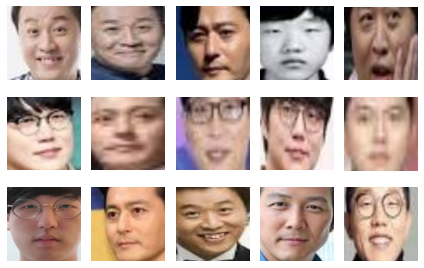

In [15]:
fig, axes = plt.subplots(3,5)
axes = axes.ravel()
rank_15 = rank[:15]

for ind, axis in enumerate(axes):
    axis.imshow(cropped_images[rank_15[ind]])
    axis.axis("off")
plt.tight_layout()
plt.show()

얼굴 임베딩되어진 이미지중에서 재 얼굴과 L2 거리가 짧고 가장 유사성이 높은 상위 15개의 이미지를 출력하였더니 그럴만 하다는 생각이 들었습니다.

## 5. 다양한 재미있는 시각화 시도해 보기

지금부터 앞에서 구한 이미지별 벡터거리를 점수화시켜서 자신의 얼굴과 유사성이 높은 상위 5명의 연예인을 골라서 원 도표로 표현해보겠습니다.  
이 점수의 의미는 자신의 얼굴에서 5명의 연예인이 몇퍼센트씩 유사성을 보이는지 수치적으로 표현한 것입니다.

In [16]:
dict_distance = dict(distance)
print(dict_distance.keys())
new_key = list(map(lambda x: re.sub("[^가-힣a-zA-Z]", "", x), dict_distance.keys()))
new_value = dict_distance.values()

dict_keys(['정준하11', '정준하1', '장동건0', '김제동14', '정준하10', '성시경3', '장동건11', '유재석3', '성시경1', '장동건6', 'my_face_2', '장동건2', '정준하7', '이정재9', '김제동18', '유희열8', '원빈12', '이정재10', '유희열5', '유재석13', '유재석6', '유희열11', '정준하0', '장동건9', '정준하19', '장동건8', '유희열6', '장동건3', '장동건4', '김제동3', '성시경16', '김제동7', '장동건14', '이정재13', '성시경13', '김제동16', '김제동1', '김제동5', '이정재8', '유재석18', '김제동9', '유희열7', '이정재12', '장동건15', '유희열2', '이정재2', '성시경4', '유희열10', '유희열18', '김제동11', '장동건16', '장동건7', '정준하6', '이정재5', '정준하4', '장동건17', '장동건1', '김제동15', '이정재1', '유희열1', '이정재0', '이정재14', '정준하12', '이정재6', '김제동2', '원빈6', '원빈19', '유희열9', '유희열12', '유재석12', '정준하9', '원빈18', '원빈1', '이정재3', '유희열3', '유희열13', '원빈5', '원빈10', '원빈3'])


같은 연예인 사진이 20개정도 존재해서 이름뒤에 숫자가 붙어있는 상태인데 이 상태에서 점수를 구하기는 어렵기 때문에 숫자를 떼준 새로운 딕셔너리를 만들어 주었습니다.

In [17]:
mean_distance = pd.DataFrame({"key": new_key, "score":new_value}).groupby("key").mean().sort_values("score")[:5]
mean_distance

,score
key,
myface,1.503594
성시경,1.653823
장동건,1.701763
정준하,1.723587
유재석,1.757125


제 얼굴 임베딩 벡터와 20개의 이미지별 임베딩 벡터의 평균 거리를 구하고 그 중에서 짧은 거리를 가진 연예인 5명을 골라냈습니다.

In [18]:
total = sum(mean_distance["score"]) 
score = (total - mean_distance)
score = (score / sum(score["score"])) * 100
score

,score
key,
myface,20.492765
성시경,20.042432
장동건,19.898727
정준하,19.833304
유재석,19.732772


5명의 연예인이 각각 차지하는 비율을 퍼센트로 표현하였습니다.

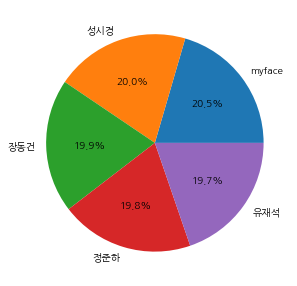

In [19]:
score.plot.pie(y='score', figsize=(5, 5), autopct="%0.1f%%",startangle=0, legend=False)
plt.axis("off")
plt.show()

제 얼굴과 유사성을 가진 5명의 연예인은 myface, 성시경, 장동건, 정준하, 김제동순으로 닮았다고 할 수 있습니다.  
- myface의 경우 또 다른 제 얼굴 이미지이기 때문에 유사성이 제일 높다고 나오는 것이 정상적인 판단이라고 생각합니다.
- 다른 많은 연예인을 넣어서 유재석과 유사성이 높다고 생각했는데 성시경과 장동건이 나온것이 굉장히 의외이며 컴퓨터는 재 얼굴에서 장동건이 일부 보인다고 판단하니 외모에 근자감이 생겼습니다.
- 비교를 위한 데이터가 안경을 끼고 있어서 안경을 끼고 있는 연예인들만 뽑힐거라고 생각했는데 안경을 끼지 않은 장동건과 정준하가 나온 것이 의외의 결과라고 생각했습니다.
